# CNN Classification task using PyTorch on MNIST dataset

## `1.` Import needed libraries

In [4]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchsummary import summary

## `2.` Load the data


In [11]:
data_transform_augmented = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  
])

In [12]:
train_set = datasets.MNIST(root = './data' , train = True , download= True , transform= data_transform_augmented)
train_loader =DataLoader(train_set , batch_size= 64 , shuffle= True , drop_last=True)

In [13]:
test_set = datasets.MNIST(root = './data' , train = False , download= True , transform= data_transform_augmented)
test_loader =DataLoader(test_set , batch_size= 64 , shuffle= False , drop_last=True)

In [14]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Input shape: {data.shape}, Target shape: {target.shape}")
    break

Input shape: torch.Size([64, 1, 32, 32]), Target shape: torch.Size([64])


### plot samples of data

In [15]:
def plot_samples(samples):
  '''
  This function plots the first 9 samples form the passed dataset
  ----------------------------------
  parameters:
  samples : the dataset you want to plot samples from it

  '''
  plt.figure(figsize=(12,8))
  for i in range(9):
    plt.subplot(3, 3 , i+1)
    plt.imshow(samples[i].permute(1,2,0) , cmap = 'gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show();

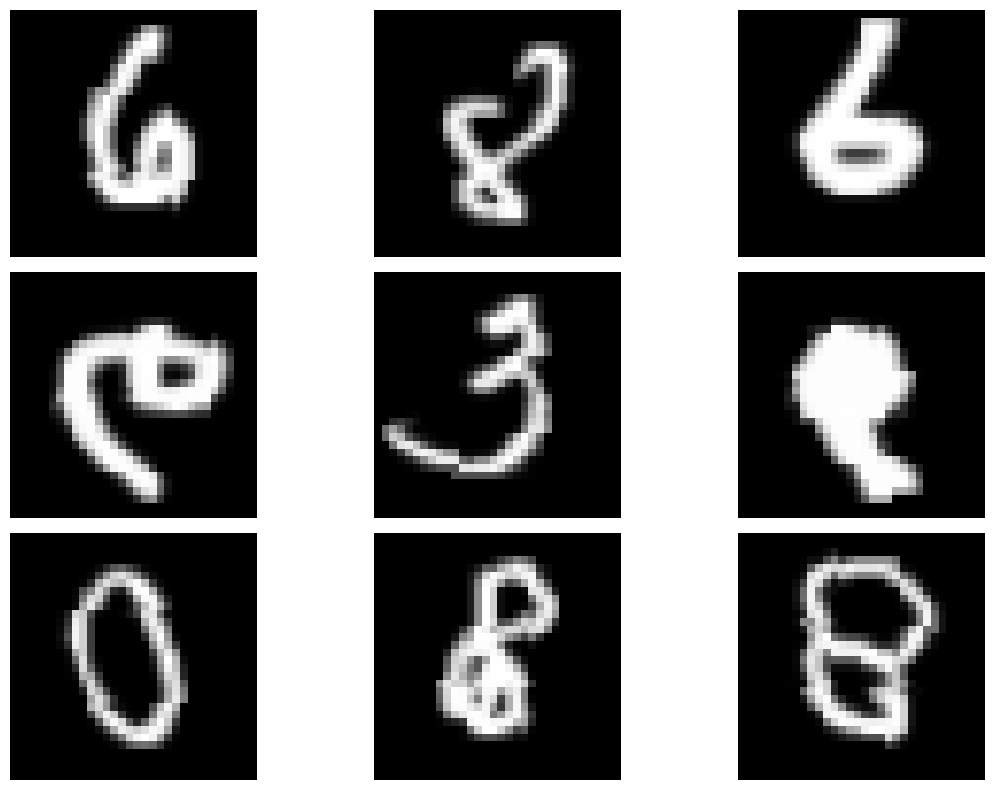

In [16]:
for batch in train_loader:
  images , labels = batch
  plot_samples(images)
  break

## `3.` Model building

### `Custom CNN architecture`

In [17]:
class Custom_CNN(nn.Module):
    def __init__(self, activation='relu', pooling='max', dropout_prob=0.0):
        super(Custom_CNN, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
        }
        self.pooling_fn = {
            'max': nn.MaxPool2d(kernel_size=2, stride=2),
            'avg': nn.AvgPool2d(kernel_size=2, stride=2)
        }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = self.pooling_fn[self.pooling]

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8* 8)
        x = self.fc1(x)
        x = self.activation_fn[self.activation](x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### `LeNet5 architecture `

In [18]:
class LeNet5(nn.Module):
    def __init__(self , activation = 'relu' , pooling = 'max' , dropout_prob = 0.0):
        super(LeNet5, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
            }
        self.pooling_fn = {
                'max': nn.MaxPool2d(kernel_size=2, stride=2),
                'avg': nn.AvgPool2d(kernel_size=2, stride=2)
            }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Average Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv1(x)))
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(self.activation_fn[self.activation](self.fc1(x)))
        x = self.dropout(self.activation_fn[self.activation](self.fc2(x)))
        x = self.fc3(x)
        return x

## `4.` Model training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
cnn_model = Custom_CNN(activation= 'relu' , pooling = 'avg' , dropout_prob= 0.3 ).to(device)
summary(cnn_model ,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         AvgPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         AvgPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [21]:
lenet_model = LeNet5(activation= 'relu' , pooling = 'avg' , dropout_prob= 0.3 ).to(device)
summary(lenet_model , input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [22]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()

In [23]:
def model_train(model, device, train_loader,test_loader, optimizer, criterion, epochs):
    model.train()

    train_losses = []
    test_accuracies = []
    test_loss = 0
    test_losses = []

    optimizers = {
        'adam': torch.optim.Adam(model.parameters()),
        'SGD' : torch.optim.SGD(model.parameters()),
        'RMSProp' : torch.optim.RMSprop(model.parameters())}

    for epoch in range(epochs):
        train_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizers[optimizer].zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizers[optimizer].step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        test_loss , accuracy = evaluate_model(model, device, test_loader)
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    visualize_results(train_losses , test_accuracies , epochs)
    return train_losses, test_losses , test_accuracies

## `5.` Model evaluation

In [24]:
def evaluate_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

## `6.` Visualizing results

In [25]:
def visualize_results(losses, accuracies, epochs):
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()


# `i` Model process

In [26]:
torch.manual_seed(42)

## CNN trainnig:

In [27]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = cnn_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 1.3209878206253052
Epoch 1, Batch 200, Loss: 0.983911395072937
Epoch 1, Batch 300, Loss: 0.8853313326835632
Epoch 1, Batch 400, Loss: 0.8066655993461609
Epoch 1, Batch 500, Loss: 0.7464519739151001
Epoch 1, Batch 600, Loss: 0.5227729082107544
Epoch 1, Batch 700, Loss: 0.6472187638282776
Epoch 1, Batch 800, Loss: 0.4960731267929077
Epoch 1, Batch 900, Loss: 0.6076791882514954
Epoch 1, Loss: 0.3938, Accuracy: 87.78%
Epoch 2, Batch 100, Loss: 0.4540557563304901
Epoch 2, Batch 200, Loss: 0.3325807750225067
Epoch 2, Batch 300, Loss: 0.2225920557975769
Epoch 2, Batch 400, Loss: 0.31228479743003845
Epoch 2, Batch 500, Loss: 0.3213871717453003
Epoch 2, Batch 600, Loss: 0.22548125684261322
Epoch 2, Batch 700, Loss: 0.24215394258499146
Epoch 2, Batch 800, Loss: 0.288068026304245
Epoch 2, Batch 900, Loss: 0.2820625305175781
Epoch 2, Loss: 0.2613, Accuracy: 92.60%
Epoch 3, Batch 100, Loss: 0.21836964786052704
Epoch 3, Batch 200, Loss: 0.19254575669765472
Epoch 3, Batch 30

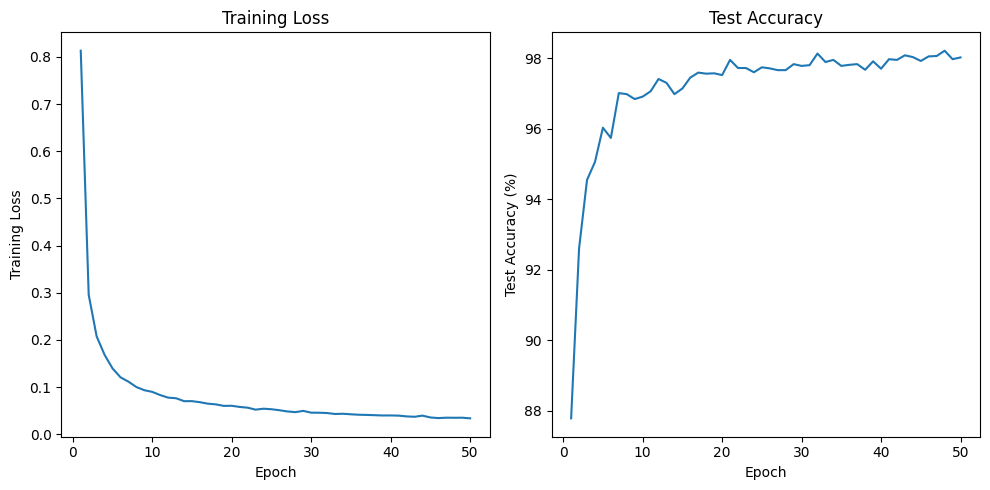

In [28]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

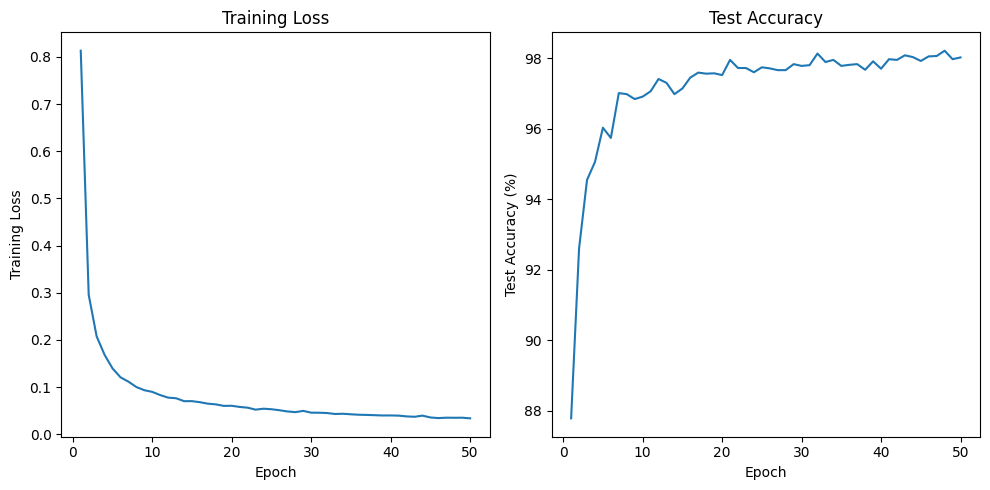

In [29]:
visualize_results(cnn_losses ,cnn_accuracies ,num_epochs )

## LeNet trainnig:

In [30]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = lenet_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 1.339216709136963
Epoch 1, Batch 200, Loss: 1.0673243999481201
Epoch 1, Batch 300, Loss: 0.9699999690055847
Epoch 1, Batch 400, Loss: 0.7576813697814941
Epoch 1, Batch 500, Loss: 0.6921750903129578
Epoch 1, Batch 600, Loss: 0.6079797148704529
Epoch 1, Batch 700, Loss: 0.5915272831916809
Epoch 1, Batch 800, Loss: 0.6029326915740967
Epoch 1, Batch 900, Loss: 0.4096716046333313
Epoch 1, Loss: 0.5930, Accuracy: 88.30%
Epoch 2, Batch 100, Loss: 0.2264331430196762
Epoch 2, Batch 200, Loss: 0.3987075984477997
Epoch 2, Batch 300, Loss: 0.22906172275543213
Epoch 2, Batch 400, Loss: 0.25963735580444336
Epoch 2, Batch 500, Loss: 0.2834089398384094
Epoch 2, Batch 600, Loss: 0.33139580488204956
Epoch 2, Batch 700, Loss: 0.10270221531391144
Epoch 2, Batch 800, Loss: 0.44484660029411316
Epoch 2, Batch 900, Loss: 0.217956081032753
Epoch 2, Loss: 0.2670, Accuracy: 93.41%
Epoch 3, Batch 100, Loss: 0.3167097866535187
Epoch 3, Batch 200, Loss: 0.19217327237129211
Epoch 3, Batch 3

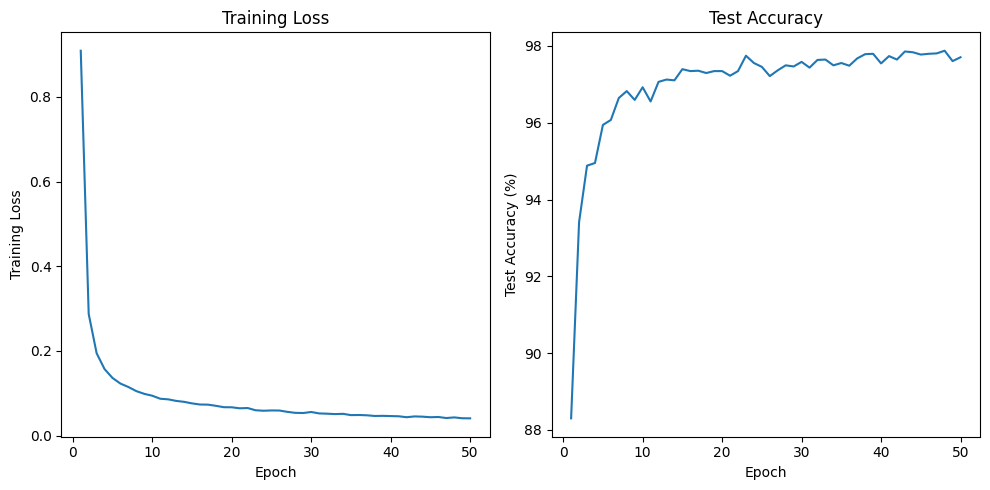

In [31]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

# Try different approaches 

In [32]:
cnn_model =Custom_CNN(activation= 'relu' , pooling = 'max' , dropout_prob= 0.2).to(device)
summary(cnn_model , (1,32 ,32 ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 1.0630385875701904
Epoch 1, Batch 200, Loss: 0.8405445218086243
Epoch 1, Batch 300, Loss: 0.4622872769832611
Epoch 1, Batch 400, Loss: 0.4971853792667389
Epoch 1, Batch 500, Loss: 0.515058159828186
Epoch 1, Batch 600, Loss: 0.5269665718078613
Epoch 1, Batch 700, Loss: 0.414364755153656
Epoch 1, Batch 800, Loss: 0.3142194449901581
Epoch 1, Batch 900, Loss: 0.30218571424484253
Epoch 1, Loss: 0.4443, Accuracy: 91.61%
Epoch 2, Batch 100, Loss: 0.1529184877872467
Epoch 2, Batch 200, Loss: 0.30306801199913025
Epoch 2, Batch 300, Loss: 0.14973866939544678
Epoch 2, Batch 400, Loss: 0.2727656960487366
Epoch 2, Batch 500, Loss: 0.17261578142642975
Epoch 2, Batch 600, Loss: 0.080231674015522
Epoch 2, Batch 700, Loss: 0.16981428861618042
Epoch 2, Batch 800, Loss: 0.2738194465637207
Epoch 2, Batch 900, Loss: 0.2313251793384552
Epoch 2, Loss: 0.0960, Accuracy: 94.67%
Epoch 3, Batch 100, Loss: 0.2354503571987152
Epoch 3, Batch 200, Loss: 0.041201718151569366
Epoch 3, Batch 3

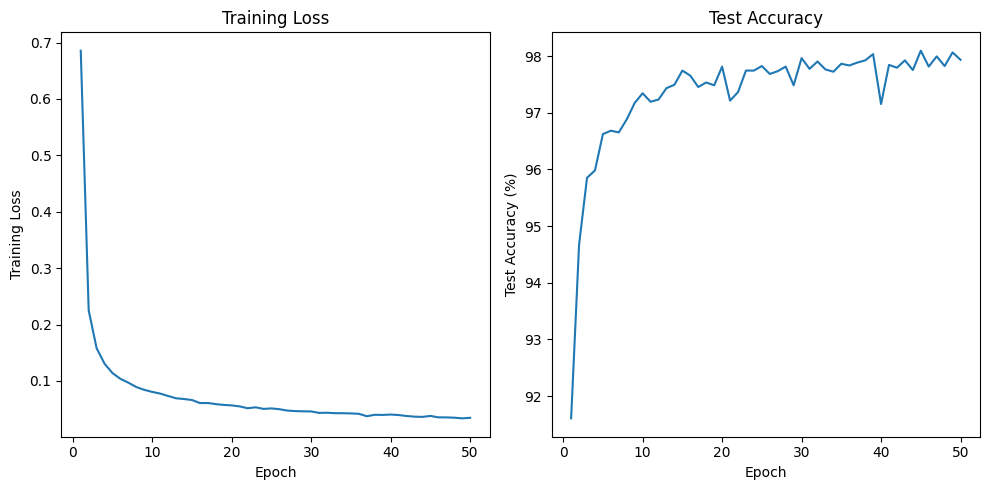

In [33]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)

In [34]:
lenet_model  = LeNet5( activation= 'relu' ,pooling = 'max' , dropout_prob= 0.2).to(device)
summary(lenet_model , (1 , 32 ,32 )) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 1.3340290784835815
Epoch 1, Batch 200, Loss: 0.925894021987915
Epoch 1, Batch 300, Loss: 0.7940855026245117
Epoch 1, Batch 400, Loss: 0.7691604495048523
Epoch 1, Batch 500, Loss: 0.6092866063117981
Epoch 1, Batch 600, Loss: 0.5189260840415955
Epoch 1, Batch 700, Loss: 0.5697320699691772
Epoch 1, Batch 800, Loss: 0.3943508565425873
Epoch 1, Batch 900, Loss: 0.31777647137641907
Epoch 1, Loss: 0.3692, Accuracy: 90.54%
Epoch 2, Batch 100, Loss: 0.13074839115142822
Epoch 2, Batch 200, Loss: 0.28170350193977356
Epoch 2, Batch 300, Loss: 0.2940369248390198
Epoch 2, Batch 400, Loss: 0.17969562113285065
Epoch 2, Batch 500, Loss: 0.14565151929855347
Epoch 2, Batch 600, Loss: 0.18300670385360718
Epoch 2, Batch 700, Loss: 0.18987403810024261
Epoch 2, Batch 800, Loss: 0.30346396565437317
Epoch 2, Batch 900, Loss: 0.3107012212276459
Epoch 2, Loss: 0.2097, Accuracy: 94.53%
Epoch 3, Batch 100, Loss: 0.193448007106781
Epoch 3, Batch 200, Loss: 0.18411581218242645
Epoch 3, Batc

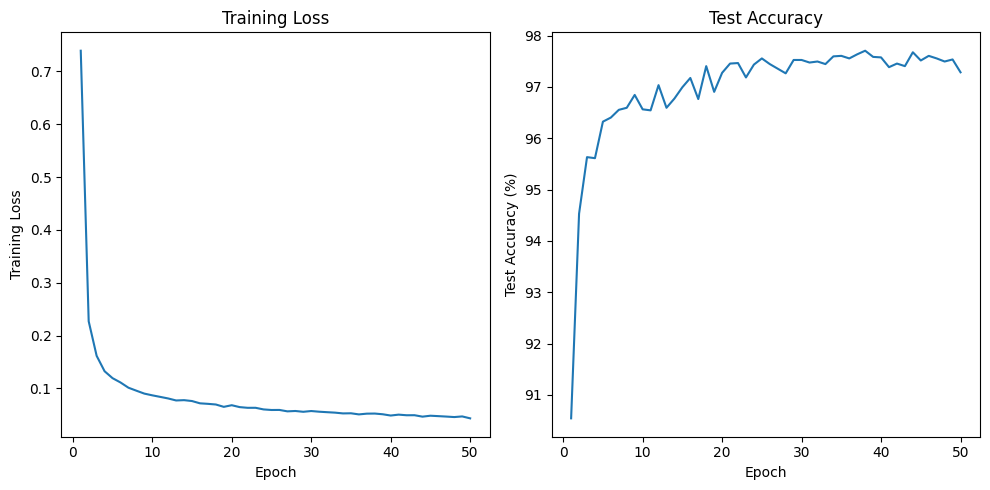

In [35]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'adam', criterion, num_epochs)